# Tool results comparison on simulated data
first import libraries 


In [200]:
import os

results_dir = "/net/phage/linuxhome/mgx/people/rickb/sassy/roux_paper/test_myers/spacer_bench/results/run_t_1_nc_10000_ns_1000_ir_1_100_lm_0_3_prc_0.5/"
sim_data_dir = f"{results_dir}/simulated_data/"

os.chdir(results_dir)
os.makedirs('./results/simulated/plots/', exist_ok=True)
os.makedirs('./results/simulated/results/', exist_ok=True)

import polars as pl
import matplotlib.pyplot as plt
# import glob
import altair as alt
import numpy as np
from bench.utils.functions import *
pl.Config.set_tbl_cols(n=-1)

# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)

polars.config.Config

misc function to aggregate the results of multiple simulation runs. Is should only be ran once, and the output of it (once compressed) will be available in the zenodo deposit.


In [ ]:
# %%bash
# cd /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/simulated/Runs/
# mkdir -p ./combined_sims/simulated_data

# # sequence files
# cat  ./sims/run_t_*/simulated_data/simulated_contigs.fa >./combined_sims/simulated_data/simulated_contigs.fa
# cat  ./sims/run_t_*/simulated_data/simulated_spacers.fa >./combined_sims/simulated_data/simulated_spacers.fa

# # ground truths
# header_line=$(head -n 1 ./sims/run_t_*/simulated_data/ground_truth.tsv | tail -n1 )
# echo "$header_line" > ./combined_sims/simulated_data/ground_truth.tsv
# for f in ./sims/run_t_*/simulated_data/ground_truth.tsv; do
#     tail -n +2 "$f" >> ./combined_sims/simulated_data/ground_truth.tsv
# done

# # tool results
# header_line=$(head -n 1 ./sims/run_t_*/tools_results.tsv | tail -n1)
# echo "$header_line" > ./combined_sims/tools_results.tsv
# for f in ./sims/run_t_*/tools_results.tsv; do
#     tail -n +2 "$f" >> ./combined_sims/tools_results.tsv
# done

# # wc -l ./combined_sims/tools_results.tsv
# # sort -u ./combined_sims/tools_results.tsv | wc -l
# cd /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/

Then load data

In [201]:
path = f"{sim_data_dir}myers_ground_truth.tsv"
print(path)
all_ground_truth = pl.read_csv(path, separator="\t").drop_nulls()
#all_tool_results = pl.read_csv(source="./results/simulated/Runs/combined_sims/tools_results.tsv.zst", separator="\t").drop_nulls()

/net/phage/linuxhome/mgx/people/rickb/sassy/roux_paper/test_myers/spacer_bench/results/run_t_1_nc_10000_ns_1000_ir_1_100_lm_0_3_prc_0.5//simulated_data/myers_ground_truth.tsv


In [202]:
all_ground_truth.head()

spacer_id,contig_id,start,end,strand,mismatches
str,str,i64,i64,bool,i64
"""32d6e68c_spacer_159""","""32d6e68c_contig_9699""",17346,17366,false,3
"""32d6e68c_spacer_159""","""32d6e68c_contig_5616""",7578,7596,true,3
"""32d6e68c_spacer_159""","""32d6e68c_contig_5616""",7578,7597,true,2
"""32d6e68c_spacer_159""","""32d6e68c_contig_5616""",7578,7598,true,1
"""32d6e68c_spacer_159""","""32d6e68c_contig_5616""",7578,7599,true,0


Myers returns ALL positions within the k cutoff, merge intervals

In [203]:
# First filter on max 3 edits <=3
all_ground_truth = all_ground_truth.filter(pl.col("mismatches") <= 3)
print(all_ground_truth.height)

215663


Merge intervals, group by contig_id, spacer_id, and merge overlaps using interval trees

In [204]:
from intervaltree import IntervalTree


WIGGLE_ROOM = 5

def merge_overlapping_intervals_with_min_mismatches(df, output_file="merged_intervals.tsv"):
    """
    Group by contig_id, spacer_id, strand, then merge overlapping intervals
    based on (start,end) creating a new overlap where the data is the min(mismatches)
    Write to TSV to avoid pyarrow issues
    """
    
    merged_intervals = []
    
    # Use polars groupby and iterate through groups
    for group_key, group_df in df.group_by(['contig_id', 'spacer_id', 'strand']):
        contig_id, spacer_id, strand = group_key
        
        # Create interval tree for this group
        tree = IntervalTree()
        
        # Add all intervals to the tree with their mismatches as data
        for row in group_df.iter_rows(named=True):
            tree.addi(row['start'], row['end'], row['mismatches'])
        
        # Merge overlapping intervals
        tree.merge_overlaps(data_reducer=lambda current, new: min(current, new))
        
        # Extract merged intervals
        for interval in tree:
            merged_intervals.append({
                'contig_id': contig_id,
                'spacer_id': spacer_id,
                'strand': strand,
                'start': interval.begin - WIGGLE_ROOM,
                'end': interval.end + WIGGLE_ROOM,
                'mismatches': interval.data
            })
    
    merged_df = pl.DataFrame(merged_intervals)
    merged_df.write_csv(output_file)
    
    print(f"Merged intervals written to: {output_file}")
    print(f"Shape: {merged_df.shape}")
    
    return output_file

# Function to read back the merged intervals
def read_merged_intervals(file_path="merged_intervals.tsv"):
    """
    Read merged intervals from TSV file back into polars DataFrame
    """
    return pl.read_csv(file_path, separator=",")



In [205]:
merged_truth = merge_overlapping_intervals_with_min_mismatches(all_ground_truth)

Merged intervals written to: merged_intervals.tsv
Shape: (53855, 6)


In [206]:
ground_truth_intervals = read_merged_intervals()

In [207]:
ground_truth_intervals.head()

contig_id,spacer_id,strand,start,end,mismatches
str,str,bool,i64,i64,i64
"""32d6e68c_contig_1514""","""32d6e68c_spacer_351""",false,10192,10242,2
"""32d6e68c_contig_4587""","""32d6e68c_spacer_33""",true,10745,10798,1
"""32d6e68c_contig_3382""","""32d6e68c_spacer_916""",true,12375,12407,1
"""32d6e68c_contig_5741""","""32d6e68c_spacer_358""",false,8181,8216,0
"""32d6e68c_contig_1845""","""32d6e68c_spacer_177""",false,10773,10832,2


In [208]:
# Print reduced interval
print("Before overlap merge: ", all_ground_truth.height)
print("After interval merge: ", ground_truth_intervals.height)

Before overlap merge:  215663
After interval merge:  53855


Intervals now represent the "max" positiosn basically so every tool must be within or equal to the start ends

In [209]:
tool_results = pl.read_csv(f"{results_dir}/tools_results.tsv", separator = "\t")

In [210]:
tool_results.head()

spacer_id,contig_id,spacer_length,strand,start,end,mismatches,tool
str,str,i64,bool,i64,i64,i64,str
"""32d6e68c_spacer_579""","""32d6e68c_contig_4131""",39,true,16845,16884,0,"""bbmapskimmer"""
"""32d6e68c_spacer_125""","""32d6e68c_contig_1447""",45,false,12471,12516,0,"""bbmapskimmer"""
"""32d6e68c_spacer_699""","""32d6e68c_contig_5017""",53,true,12566,12619,0,"""bbmapskimmer"""
"""32d6e68c_spacer_117""","""32d6e68c_contig_2101""",38,true,8272,8310,1,"""bbmapskimmer"""
"""32d6e68c_spacer_509""","""32d6e68c_contig_2037""",36,true,1267,1303,0,"""bbmapskimmer"""


In [211]:
sassy_results = tool_results.filter(pl.col("tool") == "sassy")
sassy_results = sassy_results.filter(pl.col("mismatches") <= 3)


In [212]:
print("Sassy reesults: ", sassy_results.height)
print("Max mismatches: ", sassy_results["mismatches"].max())

Sassy reesults:  53936
Max mismatches:  3


In [213]:
def compare_to_gt(
    ground_truth: pl.DataFrame, 
    results_df: pl.DataFrame,
):

    match_columns = ["contig_id", "spacer_id"]
    interval_columns = ("start", "end")
    
    start_col, end_col = interval_columns
    
    # Add row indices to track unique rows
    gt_indexed = ground_truth.with_row_index("gt_row_id")
    results_indexed = results_df.with_row_index("results_row_id")
    
    # Build join conditions
    interval_conditions = (
        (pl.col(start_col) <= pl.col(f"{start_col}_right")) &  # gt.start <= results.start
        (pl.col(end_col) >= pl.col(f"{end_col}_right"))       # gt.end >= results.end
    )
    
    # Add exact match conditions
    exact_match_conditions = pl.lit(True)  # Start with True
    for col in match_columns:
        exact_match_conditions = exact_match_conditions & (
            pl.col(col) == pl.col(f"{col}_right")
        )
    
    # Combine all conditions
    join_conditions = interval_conditions & exact_match_conditions
    
    # Perform the join
    joined = gt_indexed.join_where(
        results_indexed,
        join_conditions,
        suffix="_right"
    )
    
    # Calculate metrics
    tp = joined.height
    fn = gt_indexed.height - len(joined.select("gt_row_id").unique())
    fp = results_indexed.height - len(joined.select("results_row_id").unique())
    
    return {
        "TP": tp,
        "FN": fn, 
        "FP": fp
    }


In [214]:
compare_to_gt(ground_truth_intervals, sassy_results)

{'TP': 53936, 'FN': 0, 'FP': 0}

It seems hisat2 had no restruction on the max gap length, so to save some time, we will remove all extracted contig regions that are longer than 130 bp.  
120bp was the max length of the spacer sequences, so this should be a good compromise.

In [215]:
print(all_tool_results.height)
all_tool_results = all_tool_results.filter(pl.col("contig_seq").str.len_chars() <= 130)
print(all_tool_results.height)

NameError: name 'all_tool_results' is not defined

In [11]:
mini_tool_results = all_tool_results.select(["spacer_id","contig_id","start","end","strand","spacer_seq","contig_seq"]).unique()
mini_tool_results.write_parquet("./results/simulated/Runs/combined_sims/simulated_data/mini_tool_results_wseqs.parquet")

In [12]:
mini_tool_results

spacer_id,contig_id,start,end,strand,spacer_seq,contig_seq
str,str,i64,i64,bool,str,str
"""be5a3e47_spacer_333""","""be5a3e47_contig_11534""",45902,45974,true,"""TGTCATAGACGCCAGGGTATACAACGCCTA…","""TGTCATAGACGCCAGGGTATACAACGCTTA…"
"""46cbe5cc_spacer_1006""","""46cbe5cc_contig_39437""",7151,7226,false,"""TGATAGAGCTCGACGGACGCTGGTGTTGTA…","""TGATAGAGCTCGACGGACGCTGGTGTTGTA…"
"""2f5f82c2_spacer_621""","""2f5f82c2_contig_15791""",102936,103032,false,"""TACAGTCGAAACCAGCGGCGTGCAAGCCGA…","""TACAGTCGAAACCAGCGGCGTGCAAGCCGA…"
"""bdd1ae3d_spacer_545""","""bdd1ae3d_contig_26476""",34865,34948,true,"""TCGAGCCTTTGATTAGCAGTAAAATGCAGA…","""TCGAGCCTTTGATTAGCAGTAAACTGCAGA…"
…,…,…,…,…,…,…
"""7e31dd51_spacer_615""","""7e31dd51_contig_32669""",34739,34824,true,"""TCTTTCTCGCTTAGGATGGCCTCAGCGTTT…","""TCTTTCTCGCTTAGGATGGCCTCAGCGTTT…"
"""2f5f82c2_spacer_391""","""2f5f82c2_contig_36020""",74389,74426,true,"""TCGCTTATTCTATAAAGGCGAGCTGCCACC…","""TCGCTTATTCTATAAAGGCGAGCTGCCACC…"
"""3be9ac2e_spacer_351""","""3be9ac2e_contig_6677""",82198,82253,true,"""CGAAGCCGACGCCCCCGTGGTCGGATGTAT…","""CGAAGCCGACGCCCCCGTGGTCGGATGTAT…"
"""49008d1d_spacer_594""","""49008d1d_contig_16413""",8341,8418,false,"""ATAAGCTTATACTCGGAACCCCAAAGATGA…","""ATAAGCTTATACTCGGAACCGCAAAGATAA…"


And testing the alignments:

In [13]:
in_ground_truth = mini_tool_results.join(all_ground_truth_verified.select(["spacer_id","contig_id","start","end","strand"]),on=['spacer_id','contig_id','start','end','strand'],how='inner')
not_in_ground_truth = mini_tool_results.join(all_ground_truth_verified.select(["spacer_id","contig_id","start","end","strand"]),on=['spacer_id','contig_id','start','end','strand'],how='anti') 
print(f"Number of tool results in ground truth: {in_ground_truth.height}")
print(f"Number of tool results *not* in ground truth: {not_in_ground_truth.height}")

Number of tool results in ground truth: 7638511
Number of tool results *not* in ground truth: 1960029


only recalc the alignments for the tool results that are not in the ground truth, as we just tested those...


In [216]:
print("testing remaining alignments")
mini_recalced_results = test_alignment_polars(not_in_ground_truth, ignore_region_strands=True)

testing remaining alignments


NameError: name 'not_in_ground_truth' is not defined

In [15]:
mini_recalced_results.write_parquet("./results/simulated/Runs/combined_sims/simulated_data/mini_recalced_results.parquet")

In [16]:
mini_recalced_results["alignment_test"].hist()

breakpoint,category,count
f64,cat,u32
5.1,"""[0.0, 5.1]""",1626395
10.2,"""(5.1, 10.2]""",333632
15.3,"""(10.2, 15.3]""",0
20.4,"""(15.3, 20.4]""",0
…,…,…
35.7,"""(30.6, 35.7]""",1
40.8,"""(35.7, 40.8]""",0
45.9,"""(40.8, 45.9]""",0
51.0,"""(45.9, 51.0]""",1


Let's test several of these high error rate alignments to see if they are correct.

In [17]:
tmp_err = mini_recalced_results.filter(pl.col("alignment_test") > 10)
for xc in range(0,5):
    # print(f"mismatches: {n_mis}")
    ix = np.random.randint(0,tmp_err.height)

    print(f"Spacer id: {tmp_err[ix,'spacer_id']}")
    print(f"Contig id: {tmp_err[ix,'contig_id']}")
    print(f"Alignment test: {tmp_err[ix,'alignment_test']}")
    # print(f"Rust simulation mismatch report: {tmp_err[ix,'mismatches']}")
    print(prettify_alignment(contig_seq=tmp_err[ix,'contig_seq'],spacer_seq=tmp_err[ix,'spacer_seq']))
    print("\n")

Spacer id: be5a3e47_spacer_89
Contig id: be5a3e47_contig_2108
Alignment test: 51
AGGTCCATCAGAGAGAGGGTTCCGATGCCACC-G--------------------------------------------------GAAACACGGCGTGAG
|||||||||||||||||||||||||||||||| |                                                  |||||||||||||||
AGGTCCATCAGAGAGAGGGTTCCGATGCCACCTGAAACACGGCGTGAGAGGAGGTCCATCAGAGAGAGGGTTCCGATGCCACCTGAAACACGGCGTGAG


Spacer id: be5a3e47_spacer_89
Contig id: be5a3e47_contig_2108
Alignment test: 51
AGGTCCATCAGAGAGAGGGTTCCGATGCCACC-G--------------------------------------------------GAAACACGGCGTGAG
|||||||||||||||||||||||||||||||| |                                                  |||||||||||||||
AGGTCCATCAGAGAGAGGGTTCCGATGCCACCTGAAACACGGCGTGAGAGGAGGTCCATCAGAGAGAGGGTTCCGATGCCACCTGAAACACGGCGTGAG


Spacer id: bdd1ae3d_spacer_509
Contig id: bdd1ae3d_contig_10277
Alignment test: 34
GGTCGGTAGAAGGGGGATTGGCTC----------------------------------CATGGGAA
||||||||||||||||||||||||                                  ||||||||
GGTCGGTAGAAGGGGGA

These appear to be cases where the same spacer inserted (occured) multiple times in the same contig, where the "padding" or distance between the two spacer insertions is such that certain tools would prefer to open a large gap, bridging the two spacer insertions, rather than reporting the slightly mismatched terminal of at least one of the spacer.


Merge back to identify the tool and tool-reported-mismatches

In [18]:
# in_ground_truth = in_ground_truth.join(all_tool_results.select(["spacer_id","contig_id","start","end","strand","mismatches","tool"]),on=['spacer_id','contig_id','start','end','strand'],how='inner')
recalced_results = all_tool_results.join(all_ground_truth_verified.select(["spacer_id","contig_id","start","end","strand","alignment_test"]),on=['spacer_id','contig_id','start','end','strand'],how='inner')
recalced_results

spacer_id,contig_id,spacer_length,strand,start,end,mismatches,tool,contig_seq,spacer_seq,alignment_test
str,str,i64,bool,i64,i64,i64,str,str,str,i32
"""2f5f82c2_spacer_147""","""2f5f82c2_contig_33701""",36,false,28860,28896,0,"""bbmapskimmer""","""CACGCATGAACTATCATCGTAAAGGTGCGA…","""CACGCATGAACTATCATCGTAAAGGTGCGA…",0
"""2f5f82c2_spacer_187""","""2f5f82c2_contig_23552""",73,true,69868,69941,0,"""bbmapskimmer""","""TGGAAGATGGGCGTAAGGTTGCTACAATGG…","""TGGAAGATGGGCGTAAGGTTGCTACAATGG…",0
"""2f5f82c2_spacer_166""","""2f5f82c2_contig_34439""",100,false,21311,21411,0,"""bbmapskimmer""","""GACTCATTGGTATGCTTACTTAAGACTCGC…","""GACTCATTGGTATGCTTACTTAAGACTCGC…",0
"""2f5f82c2_spacer_820""","""2f5f82c2_contig_14240""",56,true,29320,29376,0,"""bbmapskimmer""","""GTGGCTCGGGGGTTCGGTCGGGCGTCACTC…","""GTGGCTCGGGGGTTCGGTCGGGCGTCACTC…",0
…,…,…,…,…,…,…,…,…,…,…
"""49008d1d_spacer_796""","""49008d1d_contig_14284""",55,true,127452,127507,3,"""strobealign""","""AACTCCGGTGAATGTTGTTTGTAAGGTTGA…","""AATTCCGGTGAATGTCGTTTCTAAGGTTGA…",3
"""49008d1d_spacer_550""","""49008d1d_contig_7904""",99,false,90991,91090,3,"""strobealign""","""GGGGCCCCTTAGATCTTAAACGTATAATAA…","""GGGGCCCCTTAAATCTTAAACGTATAATAA…",3
"""49008d1d_spacer_487""","""49008d1d_contig_39948""",106,false,13871,13977,3,"""strobealign""","""ACGATTACACGTCGATCACACGCTATCACG…","""ACGATTACACGTCGATCACACGCTATCACG…",3
"""49008d1d_spacer_752""","""49008d1d_contig_8253""",96,true,9289,9385,3,"""strobealign""","""AGAGAAGTCAGCAGTGGACTAGAGTTAATT…","""TGAGAAGTCAGCACTGGACTAGAGTTAATT…",3


In [19]:
remaining_results = mini_recalced_results.join(all_tool_results.select(["spacer_id","contig_id","start","end","strand","mismatches","tool"]),on=['spacer_id','contig_id','start','end','strand'],how='left')
recalced_results = vstack_easy(remaining_results,df2_to_stack=recalced_results)

In [20]:
recalced_results

spacer_id,contig_id,start,end,strand,spacer_seq,contig_seq,alignment_test,mismatches,tool
str,str,i64,i64,bool,str,str,i32,i64,str
"""bdd1ae3d_spacer_775""","""bdd1ae3d_contig_23249""",38752,38800,true,"""CGAGAGTGGCCCTACGGGATCTTCGGTGAC…","""CGAGAGTGGCCCTACGGGATCTTCGGTGAC…",7,7,"""blastn"""
"""be5a3e47_spacer_977""","""be5a3e47_contig_3537""",18250,18267,true,"""CTCTTAACAATTATATGAT""","""CTCTTAACAATTATATG""",2,2,"""lexicmap"""
"""49008d1d_spacer_399""","""49008d1d_contig_28500""",13862,13899,false,"""CTGGCAGGCGTTTGGGACCGGGTACAGGAG…","""CTGGCAGGCGTTTGGGACCGGGCACAGCAG…",3,3,"""blastn"""
"""49008d1d_spacer_399""","""49008d1d_contig_28500""",13862,13899,false,"""CTGGCAGGCGTTTGGGACCGGGTACAGGAG…","""CTGGCAGGCGTTTGGGACCGGGCACAGCAG…",3,3,"""mmseqs2"""
…,…,…,…,…,…,…,…,…,…
"""49008d1d_spacer_796""","""49008d1d_contig_14284""",127452,127507,true,"""AATTCCGGTGAATGTCGTTTCTAAGGTTGA…","""AACTCCGGTGAATGTTGTTTGTAAGGTTGA…",3,3,"""strobealign"""
"""49008d1d_spacer_550""","""49008d1d_contig_7904""",90991,91090,false,"""GGGGCCCCTTAAATCTTAAACGTATAATAA…","""GGGGCCCCTTAGATCTTAAACGTATAATAA…",3,3,"""strobealign"""
"""49008d1d_spacer_487""","""49008d1d_contig_39948""",13871,13977,false,"""ACGATTACACGTCGATCACACGCTATCACG…","""ACGATTACACGTCGATCACACGCTATCACG…",3,3,"""strobealign"""
"""49008d1d_spacer_752""","""49008d1d_contig_8253""",9289,9385,true,"""TGAGAAGTCAGCACTGGACTAGAGTTAATT…","""AGAGAAGTCAGCAGTGGACTAGAGTTAATT…",3,3,"""strobealign"""


In [21]:
print(f"""total number of errors where the recalculated alignment is better than the simulated mismatches:
      {all_ground_truth_verified.filter(pl.col('mismatches') > pl.col('alignment_test')).height}""")
print(f"""total number of errors where the recalculated alignment is worse than the simulated mismatches:
      {all_ground_truth_verified.filter(pl.col('mismatches') < pl.col('alignment_test')).height}""")
print(f"""total number of entries where the recalculated alignment is equal to the simulated mismatches:
      {all_ground_truth_verified.filter(pl.col('alignment_test') == pl.col('mismatches')).height}""")


total number of errors where the recalculated alignment is better than the simulated mismatches:
      1254
total number of errors where the recalculated alignment is worse than the simulated mismatches:
      0
total number of entries where the recalculated alignment is equal to the simulated mismatches:
      7637257


Next, we append the verified tool results that are <= 3 mismatches to the ground truth dataframe.  
IF the extracted contigs length is not longer than 120...

In [22]:
to_add = mini_recalced_results.select(["spacer_id","contig_id","start","end","spacer_seq","contig_seq","strand","alignment_test"])\
    .unique().filter(pl.col("alignment_test") <= 3)
to_add = to_add.with_columns(
    pl.col("contig_seq").str.len_chars().alias("contig_len"),
    pl.col("spacer_seq").str.len_chars().alias("spacer_len")
)
to_add = to_add.filter(pl.col("spacer_len") <= 120).filter(pl.col("contig_len") <= 120).unique()
to_add = to_add.with_columns(pl.col("alignment_test").alias("mismatches"))
print(f"Number of tool results to add: {to_add.height}")
to_add

Number of tool results to add: 999916


spacer_id,contig_id,start,end,spacer_seq,contig_seq,strand,alignment_test,contig_len,spacer_len,mismatches
str,str,i64,i64,str,str,bool,i32,u32,u32,i32
"""49008d1d_spacer_14""","""49008d1d_contig_37088""",125621,125657,"""TGACGCCTGCCTCGTCTGCATGCTTGGCCC…","""TGACGCCTGCCTCGTCTGCAAGCTTGGCTC…",false,3,36,37,3
"""bdd1ae3d_spacer_573""","""bdd1ae3d_contig_23300""",160857,160884,"""CTTCGACAAGTCCTCCCATCGCGCAGGC""","""TTCGACAAGTCCTCCCATCTCGCAGGC""",false,2,27,28,2
"""be5a3e47_spacer_853""","""be5a3e47_contig_12183""",111478,111576,"""TTCGGTTCGGCTTGGCTCGGCATATTCGGT…","""TTCGGTTCGGCTTGGCTCGGCATATTCGGT…",true,1,98,99,1
"""46cbe5cc_spacer_484""","""46cbe5cc_contig_11589""",37395,37439,"""GAAATTTCATATGAAGACGACGGCTAAGGG…","""GATTTCATATGAAGACGACGGCTAAGGGCC…",false,3,44,46,3
…,…,…,…,…,…,…,…,…,…,…
"""49008d1d_spacer_645""","""49008d1d_contig_35554""",75417,75465,"""TAAGGGTAGACCTCGACGGACTCGTATCTA…","""TAAGGGTAGACCTCGGCGGACTCGTATCTA…",true,3,48,49,3
"""3be9ac2e_spacer_330""","""3be9ac2e_contig_33131""",23521,23639,"""AGTGTGAGGGTAAACTAGCATACCGCACGT…","""AGTGTGAGGGTAAACTAGCATACCGCACGT…",true,3,118,119,3
"""5ae47242_spacer_313""","""5ae47242_contig_29311""",18559,18577,"""TTCCACTGTACTTTCTAT""","""TGCCCTTGTACTTTCTAT""",true,3,18,18,3
"""49008d1d_spacer_316""","""49008d1d_contig_2362""",70876,70894,"""CCAGTGGCAAGAGGTAAT""","""CCTGTGGCAACAGGCAAT""",false,3,18,18,3


In [ ]:
to_add["mismatches"].hist()

breakpoint,category,count
f64,cat,u32
0.3,"""[0.0, 0.3]""",13
0.6,"""(0.3, 0.6]""",0
0.9,"""(0.6, 0.9]""",0
1.2,"""(0.9, 1.2]""",68612
…,…,…
2.1,"""(1.8, 2.1]""",224044
2.4,"""(2.1, 2.4]""",0
2.7,"""(2.4, 2.7]""",0
3.0,"""(2.7, 3.0]""",707247


Reassuringly, the distribution of these increases with the number of mismatches.

For now, I will append the verified tool results that are <= 3 mismatches to the ground truth dataframe. (to_add)

In [24]:
print(all_ground_truth_verified.height)
all_ground_truth_verified = vstack_easy(all_ground_truth_verified,df2_to_stack=to_add)
print(all_ground_truth_verified.height)
all_ground_truth_verified.write_parquet("./results/simulated/Runs/combined_sims/simulated_data/ground_truth_verified_wseqs.parquet")

7638511
8638427


In [25]:
recalced_results = recalced_results.rename({"mismatches":"old_mismatches"}).rename({"alignment_test":"mismatches"})    

In [26]:
recalced_results["mismatches"].value_counts().sort(by="count", descending=True)

mismatches,count
i32,u32
0,17651128
1,14755712
2,12878403
3,11816867
…,…
6,247588
7,162186
34,1
51,1


Next we can start defining the true positives, false positives, and false negatives.

In [6]:
all_true_positives = recalced_results.join(all_ground_truth_verified.select(["spacer_id","contig_id","start","end","strand"]), on=['spacer_id','contig_id','start','end','strand'], how='inner')
all_false_positives = recalced_results.join(all_ground_truth_verified.select(["spacer_id","contig_id","start","end","strand"]), on=['spacer_id','contig_id','start','end','strand'], how='anti')
all_false_positives.write_parquet("./results/simulated/Runs/combined_sims/simulated_data/false_positives.parquet")
print(f"Number of false positives: {all_false_positives.height}")
print(f"Number of true positives: {all_true_positives.height}")

Number of false positives: 1527028
Number of true positives: 57102110


Check if any entries in the ground truth are missing 

In [28]:
False_negatives = all_ground_truth_verified.join(recalced_results.select(["spacer_id","contig_id","start","end","strand"]),on=['spacer_id','contig_id','start','end','strand'],how='anti')
print(f"Number of false negatives: {False_negatives.height}")
False_negatives.write_parquet("./results/simulated/Runs/combined_sims/simulated_data/false_negatives.parquet")

Number of false negatives: 0


This suggest that no single spacer occurence is missing from all all tools. We need to keep in mind each specific tool may have different false negatives.

Finally, we'll drop/rename the mismatches column from all the tables to old_mismatches and rename the alignment_test column to mismatches. 

In [9]:
all_ground_truth_verified = all_ground_truth_verified.rename({"mismatches":"old_mismatches"}).rename({"alignment_test":"mismatches"})

Calculate performance metrics for each tool and mismatch level

In [30]:
recalced_results.write_parquet("./results/simulated/Runs/combined_sims/simulated_data/recalced_results.parquet")

In [188]:
tool_results.head()

spacer_id,contig_id,spacer_length,strand,start,end,mismatches,tool
str,str,i64,bool,i64,i64,i64,str
"""e62a956e_spacer_3""","""e62a956e_contig_330""",42,true,15887,15929,1,"""bbmapskimmer"""
"""e62a956e_spacer_7""","""e62a956e_contig_575""",32,false,1395,1427,0,"""bbmapskimmer"""
"""e62a956e_spacer_2""","""e62a956e_contig_722""",48,false,792,840,0,"""bbmapskimmer"""
"""e62a956e_spacer_0""","""e62a956e_contig_791""",38,false,7528,7566,0,"""bbmapskimmer"""
"""e62a956e_spacer_1""","""e62a956e_contig_488""",40,true,5985,6025,0,"""bbmapskimmer"""


In [217]:


resdf = pl.DataFrame(schema={"tool": pl.Utf8,"true_positives": pl.Int64,"false_positives": pl.Int64,"false_negatives": pl.Int64,"ground_truth_total": pl.Int64,"precision": pl.Float64,"recall": pl.Float64,"f1_score": pl.Float64,"mismatches": pl.Int64})

#all_tools = recalced_results["tool"].unique()

tools = tool_results['tool'].unique()

all_mismatches = range(0,4)
for mismatches in all_mismatches:
    
    # Get ground truth for this mismatch level
    mismatch_gt = ground_truth_intervals.filter(pl.col("mismatches") == mismatches)
    ground_truth_total = mismatch_gt.height

    # Then for each tool we use check gt funciton
    for tool in tools:
        tool_df = tool_results.filter((pl.col("tool") == tool) & (pl.col("mismatches") == mismatches))
        res = compare_to_gt(mismatch_gt, tool_df)

        true_positives = res["TP"]
        false_negatives = res["FN"]
        false_positives = res["FP"]

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        # print(f"precision: {precision} for {mismatches} mismatches") if precision != 1 else None
        # print(f"true positives: {true_positives} false positives: {false_positives} false negatives: {false_negatives} ground truth total: {ground_truth_total}") 
        recall = true_positives / ground_truth_total if ground_truth_total > 0 else 0 # recall is equivalent to detection rate. tp + fn = ground truth total so using it .
        # print(f"true positives: {true_positives}  + false_negatives: {false_negatives} = {true_positives + false_negatives} and ground truth total =  {ground_truth_total} which are {ground_truth_total == (true_positives + false_negatives)}") 
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Add to results dataframe
        new_row = pl.DataFrame({
            "tool": [tool],
            "true_positives": [int(true_positives)],
            "false_positives": [int(false_positives)],
            "false_negatives": [int(false_negatives)],
            "ground_truth_total": [int(ground_truth_total)],
            "precision": [float(precision)],
            "recall": [float(recall)],
            "f1_score": [float(f1_score)],
            "mismatches": [int(mismatches)]
        })
        resdf = pl.concat([resdf, new_row])
        

# Add 0 precision and recall for tools that don't have any results for a given mismatch level

# Create all possible combinations
complete_grid = (
    pl.DataFrame({
        'tool': [tool for tool in tools for _ in all_mismatches],
        'mismatches': [m for _ in tools for m in all_mismatches]
    })
)

# Join with existing results and fill missing values with 0
resdf = (
    complete_grid.join(
        resdf,
        on=['tool', 'mismatches'],
        how='left'
    ).with_columns([
        pl.col('precision').fill_null(0),
        pl.col('recall').fill_null(0),
        pl.col('f1_score').fill_null(0)
    ])
)

# Save aggregated results
resdf.write_parquet("./results/simulated/results/tool_performance_by_mismatches.parquet")
resdf.write_csv("./results/simulated/results/tool_performance_by_mismatches.tsv",separator='\t')

In [ ]:
sassy_results = tool_results.filter(pl.col("tool") == "sassy")
sassy_results = sassy_results.filter(pl.col("mismatches") <= 3)


In [ ]:
sassy_results = tool_results.filter(pl.col("tool") == "sassy")
sassy_results = sassy_results.filter(pl.col("mismatches") <= 3)


In [ ]:
sassy_results = tool_results.filter(pl.col("tool") == "sassy")
sassy_results = sassy_results.filter(pl.col("mismatches") <= 3)


In [10]:
# # recalced_results = pl.read_parquet("./results/simulated/Runs/combined_sims/simulated_data/recalced_results.parquet")
# all_ground_truth_verified = pl.read_parquet("./results/simulated/Runs/combined_sims/simulated_data/ground_truth_verified_wseqs.parquet")
# all_false_positives = pl.read_parquet("./results/simulated/Runs/combined_sims/simulated_data/false_positives.parquet")
# all_false_negatives = pl.read_parquet("./results/simulated/Runs/combined_sims/simulated_data/false_negatives.parquet")
# resdf = pl.read_parquet("./results/simulated/results/tool_performance_by_mismatches.parquet")

In [11]:
import altair as alt

tools_list = recalced_results['tool'].unique().to_list()
# removing the experimental tool runs (modified parameters)
tools_list = [x for x in tools_list if x not in ["minimap2_og","minimap2_mod","mmseqs2map","bbmapskimmermod"]] 
resdf = resdf.filter(pl.col("tool").is_in(tools_list))
resdf

tool,mismatches,true_positives,false_positives,false_negatives,ground_truth_total,precision,recall,f1_score
str,i64,i64,i64,i64,i64,f64,f64,f64
"""bowtie2""",0,1899024,3,0,1899024,0.999998,1.0,0.999999
"""bowtie2""",1,1924529,3,67810,1992339,0.999998,0.965965,0.982687
"""bowtie2""",2,1573821,3,562176,2135813,0.999998,0.736872,0.848504
"""bowtie2""",3,1415300,3,1195951,2611251,0.999998,0.542001,0.702983
…,…,…,…,…,…,…,…,…
"""bbmapskimmer""",0,377426,1010,1521598,1899024,0.997331,0.198747,0.331445
"""bbmapskimmer""",1,814246,1010,1178093,1992339,0.998761,0.408688,0.580031
"""bbmapskimmer""",2,804812,1010,1331001,2135813,0.998747,0.376818,0.547187
"""bbmapskimmer""",3,760618,1010,1850633,2611251,0.998674,0.291285,0.45102


## Performance by mismatch level per tool
Now that we have the values, we can plot them

In [218]:
# First calculate the total matches per spacer-contig pair across all tools (per mismatch level)
import altair as alt

metrics = {
    'precision': 'true_positives / (true_positives + false_positives)',
    'recall': 'true_positives / (true_positives + false_negatives)',
    'f1_score': ' 2 * (precision * recall) / (precision + recall)'
}

charts = []

for metric in metrics.keys():
    base_chart = alt.Chart(resdf).mark_trail(color="tool:N").encode(
        x=alt.X("mismatches:Q", title="Number of Mismatches"),
        y=alt.Y(f"{metric}:Q", 
                title=metrics[metric],
                scale=alt.Scale(domain=[0, 1.05])
                ),
        color=alt.Color("tool:N",
                     #   legend=None
                       ),  # Hide color legend
        shape=alt.Shape("tool:N",     # Shape legend will show both shape and color
                       legend=alt.Legend(
                           title="Tool",
                           orient="right",
                           symbolFillColor="tool:N",  # Use the color encoding for fill
                           symbolStrokeColor="tool:N" # Use the color encoding for stroke
                       )),
        tooltip=['tool', 'mismatches', metric]
    ).properties(
        width=300,
        height=300,
        title=metric.title()
    )
    
    charts.append(base_chart)

# Combine charts horizontally
combined_chart = alt.hconcat(*charts).configure_axis(
    grid=True,
    gridOpacity=0.9
).configure_view(step=1,
    strokeWidth=0.1
).configure_title(
    fontSize=16,
    anchor='middle'
)
combined_chart.save('./results/simulated/plots/tool_performance_by_mismatches.html')
combined_chart.save('./results/simulated/plots/tool_performance_by_mismatches.json',format='json')

import json as json
# Save the chart specification as JSON with the correct format
chart_json = combined_chart.to_json(format="vega")

# Parse the JSON
chart_spec = json.loads(chart_json)

# Replace the legends in the specification
# We'll need to traverse the spec to find where legends are defined damn it
def update_legends_in_spec(spec):
    # Define the new legend configuration
    new_legend = {
    "orient": "right",
    "symbolSize": 190,
    "symbolOpacity": 1,
    "symbolFillColor": "shape",
    "symbolStrokeColor": "tool:N",
    "title": "Tool",
    "shape": "shape",
    "fill": "color",
    "offset": 0,
    "encode": {
        "symbols": {
            "update": {
                "fillOpacity": {"value": 0.9}
            }
        }
    }}
    if isinstance(spec, dict):
        if 'legends' in spec:
            spec['legends'] = [new_legend]
        for value in spec.values():
            update_legends_in_spec(value)
    elif isinstance(spec, list):
        for item in spec:
            update_legends_in_spec(item)
    return spec

new_chart_spec = update_legends_in_spec(chart_spec)

# Write the modified specification to a file
def change_chart_spec(new_chart_spec,output_path):
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
        <script src="https://cdn.jsdelivr.net/npm/vega@5"></script>
        <script src="https://cdn.jsdelivr.net/npm/vega-lite@5"></script>
        <script src="https://cdn.jsdelivr.net/npm/vega-embed@6"></script>
        </head>
        <body>
        <div id="vis"></div>
        <script type="text/javascript">
            var spec = {json.dumps(new_chart_spec)};
            vegaEmbed('#vis', spec);
        </script>
        </body>
        </html>
        """
        
        with open(output_path, 'w') as f:
            f.write(html_content)
# chart_spec
change_chart_spec(new_chart_spec, './results/simulated/plots/tool_performance_by_mismatches.html')


In [219]:
combined_chart

alt.HConcatChart(...)

Ignoring the mismatches just see how many of the intervals for each tool are found

In [221]:


#all_tools = recalced_results["tool"].unique()

tools = tool_results['tool'].unique()

for tool in tools:
    tool_df = tool_results.filter((pl.col("tool") == tool))
    res = compare_to_gt(mismatch_gt, tool_df)

    true_positives = res["TP"]
    false_negatives = res["FN"]
    false_positives = res["FP"]

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    # print(f"precision: {precision} for {mismatches} mismatches") if precision != 1 else None
    # print(f"true positives: {true_positives} false positives: {false_positives} false negatives: {false_negatives} ground truth total: {ground_truth_total}") 
    recall = true_positives / ground_truth_total if ground_truth_total > 0 else 0 # recall is equivalent to detection rate. tp + fn = ground truth total so using it .
    # print(f"true positives: {true_positives}  + false_negatives: {false_negatives} = {true_positives + false_negatives} and ground truth total =  {ground_truth_total} which are {ground_truth_total == (true_positives + false_negatives)}") 
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("Tool: ", tool)
    print("TP: ", true_positives)
    print("FN: ", false_negatives)
    print("FP: ", false_positives)
    print(precision)
    print(recall)
    print(f1_score)
    print()


Tool:  bbmapskimmer
TP:  6
FN:  14912
FP:  13019
0.0004606525911708253
0.0004021986861509586
0.00042944565723079125

Tool:  bowtie1
TP:  13051
FN:  1867
FP:  38900
0.25121749340724914
0.8748491754926934
0.3903453020084045

Tool:  hisat2
TP:  0
FN:  14918
FP:  12955
0.0
0.0
0

Tool:  bbmapskimmermod
TP:  5
FN:  14913
FP:  13046
0.0003831124051796797
0.0003351655717924655
0.0003575387035646609

Tool:  sassy
TP:  14955
FN:  0
FP:  38981
0.27727306437258975
1.0024802252312643
0.43439742062915737

Tool:  blastn
TP:  6505
FN:  8413
FP:  31175
0.1726380042462845
0.4360504089019976
0.24734780790144112

Tool:  strobealign
TP:  124
FN:  14794
FP:  12649
0.009707977765599311
0.008312106180453143
0.008955978476761403

Tool:  bwa_mem
TP:  386
FN:  14532
FP:  12062
0.031008997429305914
0.025874782142378334
0.028210187824307533

Tool:  bowtie2
TP:  5544
FN:  9374
FP:  33532
0.14187736718190194
0.3716315860034857
0.20535615068340926

Tool:  mummer4
TP:  3966
FN:  10952
FP:  29159
0.11972830188679245
0

## Tool vs tool comparison matrixes


In [82]:
all_charts = []
for mismatches in range(0,4):
    print(f"mismatches: {mismatches}")
    
    # Filter for current mismatch level
    tmp = recalced_results.filter(pl.col('mismatches') == mismatches)

    # Create empty matrix
    matrix = pl.DataFrame(data=np.zeros((len(tools_list), len(tools_list)), dtype=int), schema=tools_list)
    
    # Get unique pairs for each tool
    tool_pairs = {}
    for tool in tools_list:
        tool_pairs[tool] = tmp.filter(pl.col('tool') == tool).select(["contig_id","spacer_id","strand","start","end"]).unique()
    
    # Fill matrix with counts
    for i, tool_x in enumerate(tools_list):
        for j, tool_y in enumerate(tools_list):
            if tool_x == tool_y:
                continue
            # Count pairs in x but not in y
            unique_pairs = tool_pairs[tool_x].join(tool_pairs[tool_y], on=['contig_id','spacer_id','strand','start','end'], how='anti')
            matrix[i,j] = unique_pairs.height
    
    # Convert to DataFrame for better visualization
    matrix = matrix.with_columns(pl.Series(name="tool1", values=tools_list, dtype=pl.Utf8))
    print(f"Matrix for {mismatches} mismatches:")
    print(matrix)
    heatmap_filename = f'results/simulated/plots/matrix_{mismatches}'
    chart = plot_matrix(matrix, f"Matrix for mismatches == {mismatches}", heatmap_filename)
    chart.configure_text(fontSize=8)
    all_charts.append(chart)
    matrix.write_csv(f'results/simulated/results/matrix_{mismatches}.tsv',separator='\t')
    print("\n")
    chart

mismatches: 0
Matrix for 0 mismatches:
shape: (12, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ bow ┆ spa ┆ min ┆ hisat2 ┆ strob ┆ lexic ┆ bbmap ┆ mumme ┆ blast ┆ bwa_m ┆ bowti ┆ mmseq ┆ tool1 │
│ tie ┆ cer ┆ ima ┆ ---    ┆ ealig ┆ map   ┆ skimm ┆ r4    ┆ n     ┆ em    ┆ e1    ┆ s2    ┆ ---   │
│ 2   ┆ _co ┆ p2  ┆ i64    ┆ n     ┆ ---   ┆ er    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ str   │
│ --- ┆ nta ┆ --- ┆        ┆ ---   ┆ i64   ┆ ---   ┆ i64   ┆ i64   ┆ i64   ┆ i64   ┆ i64   ┆       │
│ i64 ┆ inm ┆ i64 ┆        ┆ i64   ┆       ┆ i64   ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ ent ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ --- ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ i64 ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
╞═════╪═════╪═════╪════════╪═══════╪

And now, combining the matrixes:

In [83]:
row_1 = alt.hconcat(all_charts[0],all_charts[1])
row_2 = alt.hconcat(all_charts[2],all_charts[3])
chart = alt.vconcat(row_1,row_2)
chart.save("results/simulated/plots/matrix_combined.svg")
chart.save("results/simulated/plots/matrix_combined.pdf",format="pdf")
chart

alt.VConcatChart(...)

### Summary of the pairwise matrixes
one matrix with <=3 mismatches

In [84]:
n_mismatches = 3
# Filter for current mismatch level
tmp = recalced_results.filter(pl.col('mismatches') <= n_mismatches)

# Create empty matrix
matrix = pl.DataFrame(data=np.zeros((len(tools_list), len(tools_list)), dtype=int), schema=tools_list)

# Get unique pairs for each tool
tool_pairs = {}
for tool in tools_list:
    tool_pairs[tool] = tmp.filter(pl.col('tool') == tool).select(["contig_id","spacer_id","strand","start","end"]).unique()

# Fill matrix with counts
for i, tool_x in enumerate(tools_list):
    for j, tool_y in enumerate(tools_list):
        if tool_x == tool_y:
            continue
        # Count pairs in x but not in y
        unique_pairs = tool_pairs[tool_x].join(tool_pairs[tool_y], on=['contig_id','spacer_id','strand','start','end'], how='anti')
        matrix[i,j] = unique_pairs.height

# Convert to DataFrame for better visualization
matrix = matrix.with_columns(pl.Series(name="tool1", values=tools_list, dtype=pl.Utf8))
print(f"Matrix for {n_mismatches} mismatches:")
print(matrix)
heatmap_filename = f'results/simulated/plots/matrix__less_or_equal_3_mismatches'
chart = plot_matrix(matrix, f"Matrix for mismatches <= {n_mismatches}", heatmap_filename)
# plot_matrix(matrix, f"Matrix for {n_mismatches} mismatches (% of tool's total matches)", heatmap_filename+"_percent", as_percent=True)  # as percentages
matrix.write_csv(f'results/simulated/results/matrix_less_or_equal_3_mismatches.tsv',separator='\t')
print("\n")
chart

Matrix for 3 mismatches:
shape: (12, 13)
┌─────┬─────┬─────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ bow ┆ spa ┆ min ┆ hisat2 ┆ strob ┆ lexic ┆ bbmap ┆ mumme ┆ blast ┆ bwa_m ┆ bowti ┆ mmseq ┆ tool1 │
│ tie ┆ cer ┆ ima ┆ ---    ┆ ealig ┆ map   ┆ skimm ┆ r4    ┆ n     ┆ em    ┆ e1    ┆ s2    ┆ ---   │
│ 2   ┆ _co ┆ p2  ┆ i64    ┆ n     ┆ ---   ┆ er    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ str   │
│ --- ┆ nta ┆ --- ┆        ┆ ---   ┆ i64   ┆ ---   ┆ i64   ┆ i64   ┆ i64   ┆ i64   ┆ i64   ┆       │
│ i64 ┆ inm ┆ i64 ┆        ┆ i64   ┆       ┆ i64   ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ ent ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ --- ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│     ┆ i64 ┆     ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
╞═════╪═════╪═════╪════════╪═══════╪═══════╪══════

alt.LayerChart(...)

## recall vs number of occurences

Next, we look at the differences in how we aggregate the results into bins (and what kind of bins [log,linear,fixed])
1. aggregate with contig_id
2. aggregate without contig_id   
In the first one, the number of occurrences is counted for every spacer-contig pair.    
In the second one, it's the number of occurrences per spacer across all contigs (i.e. entire reference file). These answer two different questions. In real data, we very rarely have a spacer that occurs more than twice in the same contig, but it might occur in multiple contigs. 


In [2]:
def create_spacer_counts_with_tools(all_ground_truth_verified,
                                        recalced_results
                                        , tools_list
                                        , mismatches
                                        , exact_or_max="exact"
                                        , with_contig_id=True):
    """Create a DataFrame with tool performance per spacer for simulated data."""
    # Filter for current mismatch level
    gt_subset = all_ground_truth_verified.filter(pl.col("mismatches") == mismatches if exact_or_max == "exact" else pl.col("mismatches") <= mismatches)
    tr_subset = recalced_results.filter(pl.col("mismatches") == mismatches if exact_or_max == "exact" else pl.col("mismatches") <= mismatches)
    
    # Get spacer occurrence counts from ground truth
    if with_contig_id:
        spacer_counts = gt_subset.select(["spacer_id", "contig_id"])\
            .group_by('spacer_id', 'contig_id')\
            .agg(pl.count('contig_id').alias('n_occurrences'))
    else:
        spacer_counts = gt_subset.select(["spacer_id"])\
            .group_by('spacer_id')\
            .agg(pl.count('spacer_id').alias('n_occurrences'))
    # Create a cross join of all real spacers occurrences with all tools
    if with_contig_id:
        all_combinations = spacer_counts.select('spacer_id', 'contig_id', 'n_occurrences')\
        .join(
            pl.DataFrame({'tool': tools_list}),
            how='cross'
        )
    else:
        all_combinations = spacer_counts.select('spacer_id', 'n_occurrences')\
        .join(
            pl.DataFrame({'tool': tools_list}),
            how='cross'
        )
        
    # Calculate matches per tool and spacer # 'contig_id'
    if with_contig_id:
        tool_matches = tr_subset\
            .select(['spacer_id', 'tool', 'contig_id'])\
            .group_by(['spacer_id', 'tool', 'contig_id'])\
            .agg(pl.count('contig_id').alias('tool_matches'))
    else:
        tool_matches = tr_subset\
            .select(['spacer_id', 'tool'])\
            .group_by(['spacer_id', 'tool'])\
            .agg(pl.count('spacer_id').alias('tool_matches'))
        
        
    # Join the actual matches and calculate fractions
    if with_contig_id:
        complete_fractions = all_combinations\
        .join(
            tool_matches,
            on=['spacer_id', 'contig_id', 'tool'],
            how='left'
        )\
        .with_columns([ 
            pl.col('tool_matches').fill_null(0),
            (pl.col('tool_matches') / pl.col('n_occurrences')).alias('fraction')
        ])
    else:
        complete_fractions = all_combinations\
        .join(
            tool_matches,
            on=['spacer_id', 'tool'],
            how='left'
        )\
        .with_columns([
            pl.col('tool_matches').fill_null(0),
            (pl.col('tool_matches') / pl.col('n_occurrences')).alias('fraction')
        ])

    # Pivot to get tools as columns
    if with_contig_id:
        spacer_counts_with_tools = complete_fractions\
        .pivot(
            index=['spacer_id', 'contig_id', 'n_occurrences'],
            on='tool',
            values='fraction'
        )\
        .fill_null(0)    
    else:
        spacer_counts_with_tools = complete_fractions\
        .pivot(
            index=['spacer_id', 'n_occurrences'],
            on='tool',
            values='fraction'
        )\
        .fill_null(0)    
    return spacer_counts_with_tools



In [12]:
spacer_counts = create_spacer_counts_with_tools(all_ground_truth_verified, recalced_results, tools_list, 0,with_contig_id=False)
spacer_counts.sort("n_occurrences", descending=True)

spacer_id,n_occurrences,blastn,mmseqs2,strobealign,lexicmap,minimap2,spacer_containment,bwa_mem,bbmapskimmer,mummer4,hisat2,bowtie1,bowtie2
str,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""2f5f82c2_spacer_306""",2204,1.0,0.272232,0.009074,0.278131,0.0,1.0,0.000454,0.0,1.0,1.0,1.0,1.0
"""2f5f82c2_spacer_419""",2201,1.0,0.272603,0.0,0.963199,0.0,1.0,0.000454,0.0,1.0,1.0,1.0,1.0
"""2f5f82c2_spacer_604""",2195,1.0,0.273349,0.006834,0.404556,0.0,1.0,0.000456,0.0,1.0,1.0,1.0,1.0
"""2f5f82c2_spacer_432""",2194,1.0,0.273473,0.009116,0.94804,0.0,1.0,0.000456,0.0,1.0,1.0,1.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""7e31dd51_spacer_914""",1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"""46cbe5cc_spacer_507""",1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
"""be5a3e47_spacer_479""",1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
"""be5a3e47_spacer_524""",1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


In [14]:
def plot_combined_recall_vs_occurrences(recalc_only, tools_list, n_high_occ_bins=3, 
                         output_prefix='results/simulated/plots/recall_vs_occurrences', 
                         max_bin=3, n_bins=150, color_dict=None, marker_dict=None, exact_or_max="exact",
                         plot_mismatches=[1,3],binning_method='log',with_contig_id=False):
    
    # Create color and marker dictionaries for consistent styling
    import cmap
    cmap1 = cmap.Colormap('tol:rainbow_discrete_16')
    if color_dict is None:
        color_dict = dict(zip(tools_list, cmap1.iter_colors(16)))
    if marker_dict is None:
        marker_dict = dict(zip(tools_list, ['o', 's', '^', 'D', 'v', '<', '>', 'p','x','+','*','1']))

    # Create figure with two subplots
    fig, axes = plt.subplots(len(plot_mismatches), 1, figsize=(15, 36))
    
    for i, mismatches in enumerate(plot_mismatches):
        fig_single, ax_single = plt.subplots(figsize=(15, 12))
        
        plot_on_axis(axes[i], all_ground_truth_verified, recalc_only, tools_list, n_high_occ_bins, n_bins, max_bin, 
                    mismatches=mismatches, exact_or_max=exact_or_max, color_dict=color_dict, marker_dict=marker_dict,
                    with_contig_id=with_contig_id,binning_method=binning_method)
        plot_on_axis(ax_single, all_ground_truth_verified, recalc_only, tools_list, n_high_occ_bins, n_bins, max_bin, 
                    mismatches=mismatches, exact_or_max=exact_or_max, color_dict=color_dict, marker_dict=marker_dict,
                    with_contig_id=with_contig_id,binning_method=binning_method)
        if exact_or_max == "exact":
            axes[i].set_title(f'Recall vs number of occurrences (mismatches == {mismatches})')
            ax_single.set_title(f'Recall vs number of occurrences (mismatches == {mismatches})')
        else:
            axes[i].set_title(f'Recall vs number of occurrences (mismatches ≤ {mismatches})')
            ax_single.set_title(f'Recall vs number of occurrences (mismatches ≤ {mismatches})')
    
        
        # Save single plot
        plt.figure(fig_single.number)
        plt.tight_layout()
        fig_single.savefig(f'{output_prefix}_{exact_or_max}_nm_{mismatches}.pdf', bbox_inches='tight',format='pdf')
        fig_single.savefig(f'{output_prefix}_{exact_or_max}_nm_{mismatches}.svg', bbox_inches='tight',format='svg')
        plt.close(fig_single)
    
    
    
    plt.tight_layout()
    plot_mismatches_str = "_".join([str(m) for m in plot_mismatches])
    plt.savefig(f'{output_prefix}_{exact_or_max}_nm_{plot_mismatches_str}_combined.pdf', bbox_inches='tight')
    fig.savefig(f'{output_prefix}_{exact_or_max}_nm_{plot_mismatches_str}_combined.svg', bbox_inches='tight')
    plt.show()
    plt.close()
    return fig



def create_bins(spacer_counts, n_bins, binning_method='log', n_occurrences_min=1, high_is=10**3, n_occurrences_max=10**5, n_high_occ_bins=3, max_bin=10**5):
    """Create bins based on the specified method, but always maintain logarithmic x-axis display."""
    occurrences = spacer_counts['n_occurrences']
    min_occ = max(n_occurrences_min, occurrences.min())
    max_occ = min(n_occurrences_max, occurrences.max())
    
    if binning_method == 'log':
        if n_high_occ_bins > 0:
            # Split into two ranges: regular and high occurrence
            # Regular bins from min_occ to high_is
            low_bins = np.logspace(np.log10(min_occ), np.log10(high_is), n_bins - n_high_occ_bins)
            # High occurrence bins from high_is to max_bin
            high_bins = np.logspace(np.log10(high_is), np.log10(max_bin), n_high_occ_bins + 1)[1:]  # Skip first to avoid duplicate
            bins = np.concatenate([low_bins, high_bins])
        else:
            # Single range of logarithmic bins
            bins = np.logspace(np.log10(min_occ), np.log10(max_bin), n_bins)
        return bins
        
    elif binning_method == 'linear':
        # Create linear bins in log space
        log_min = np.log10(min_occ)
        log_max = np.log10(max_bin)
        # Create linear spacing in log space, then convert back
        return np.power(10, np.linspace(log_min, log_max, n_bins))
    
    elif binning_method == 'fixed_size':
        # Sort occurrences and split into equal-sized groups
        sorted_occ = np.sort(occurrences)
        indices = np.linspace(0, len(sorted_occ), n_bins, endpoint=True).astype(int)
        bins = [min_occ]  # Start with minimum
        for idx in indices[1:-1]:
            bins.append(sorted_occ[idx])
        bins.append(max_occ)  # End with maximum
        return np.array(bins)
    else:
        raise ValueError(f"Unknown binning method: {binning_method}")



def plot_on_axis(ax, all_ground_truth_verified, recalc_only, tools_list, n_high_occ_bins, n_bins, max_bin, 
                 mismatches, exact_or_max, color_dict, marker_dict,
                 with_contig_id=True, binning_method='log'):
    
    spacer_counts_with_tools = create_spacer_counts_with_tools(all_ground_truth_verified=all_ground_truth_verified,
                                                               recalced_results=recalc_only, 
                                                               tools_list=tools_list, 
                                                               mismatches=mismatches, 
                                                               exact_or_max=exact_or_max,
                                                               with_contig_id=with_contig_id)

    # Create range bins for number of occurrences (now includes high occurrence bins)
    bins = create_bins(spacer_counts_with_tools, n_bins, n_high_occ_bins=n_high_occ_bins, max_bin=max_bin, 
                      binning_method=binning_method)
    
    # Calculate mean fraction for each tool within each bin
    bin_stats = []
    for i in range(len(bins)-1):
        mask = (spacer_counts_with_tools['n_occurrences'] >= bins[i]) & \
               (spacer_counts_with_tools['n_occurrences'] < bins[i+1])
        bin_data = spacer_counts_with_tools.filter(mask)
        if bin_data.height > 0:
            stats = {
                'bin_start': bins[i],
                'bin_end': bins[i+1],
                'n_spacers': bin_data.height
            }
            for tool in tools_list:
                stats[tool] = bin_data[tool].mean()
            bin_stats.append(stats)

    # Sort bin_stats by bin_start to ensure proper line plotting
    bin_stats.sort(key=lambda x: x['bin_start'])

    # Plot on the provided axis
    for tool in tools_list:
        x = [(stat['bin_start'] + stat['bin_end'])/2 for stat in bin_stats]
        y = [stat[tool] for stat in bin_stats]
        ax.plot(x, y, label=tool, markersize=4, linewidth=1, 
                color=color_dict[tool], markerfacecolor=color_dict[tool],
                marker=marker_dict[tool])

    ax.set_xscale('log')
    ax.set_xlabel('Number of occurrences (log scale)')
    ax.set_ylabel('Mean Detection Fraction')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.grid(True, which="major", ls="-", alpha=0.5)
    ax.minorticks_on()
    ax.set_ylim(0, 1.05)
    # Set x-axis limit based on max_bin parameter
    ax.set_xlim(1, max_bin)

ANd trying to plot


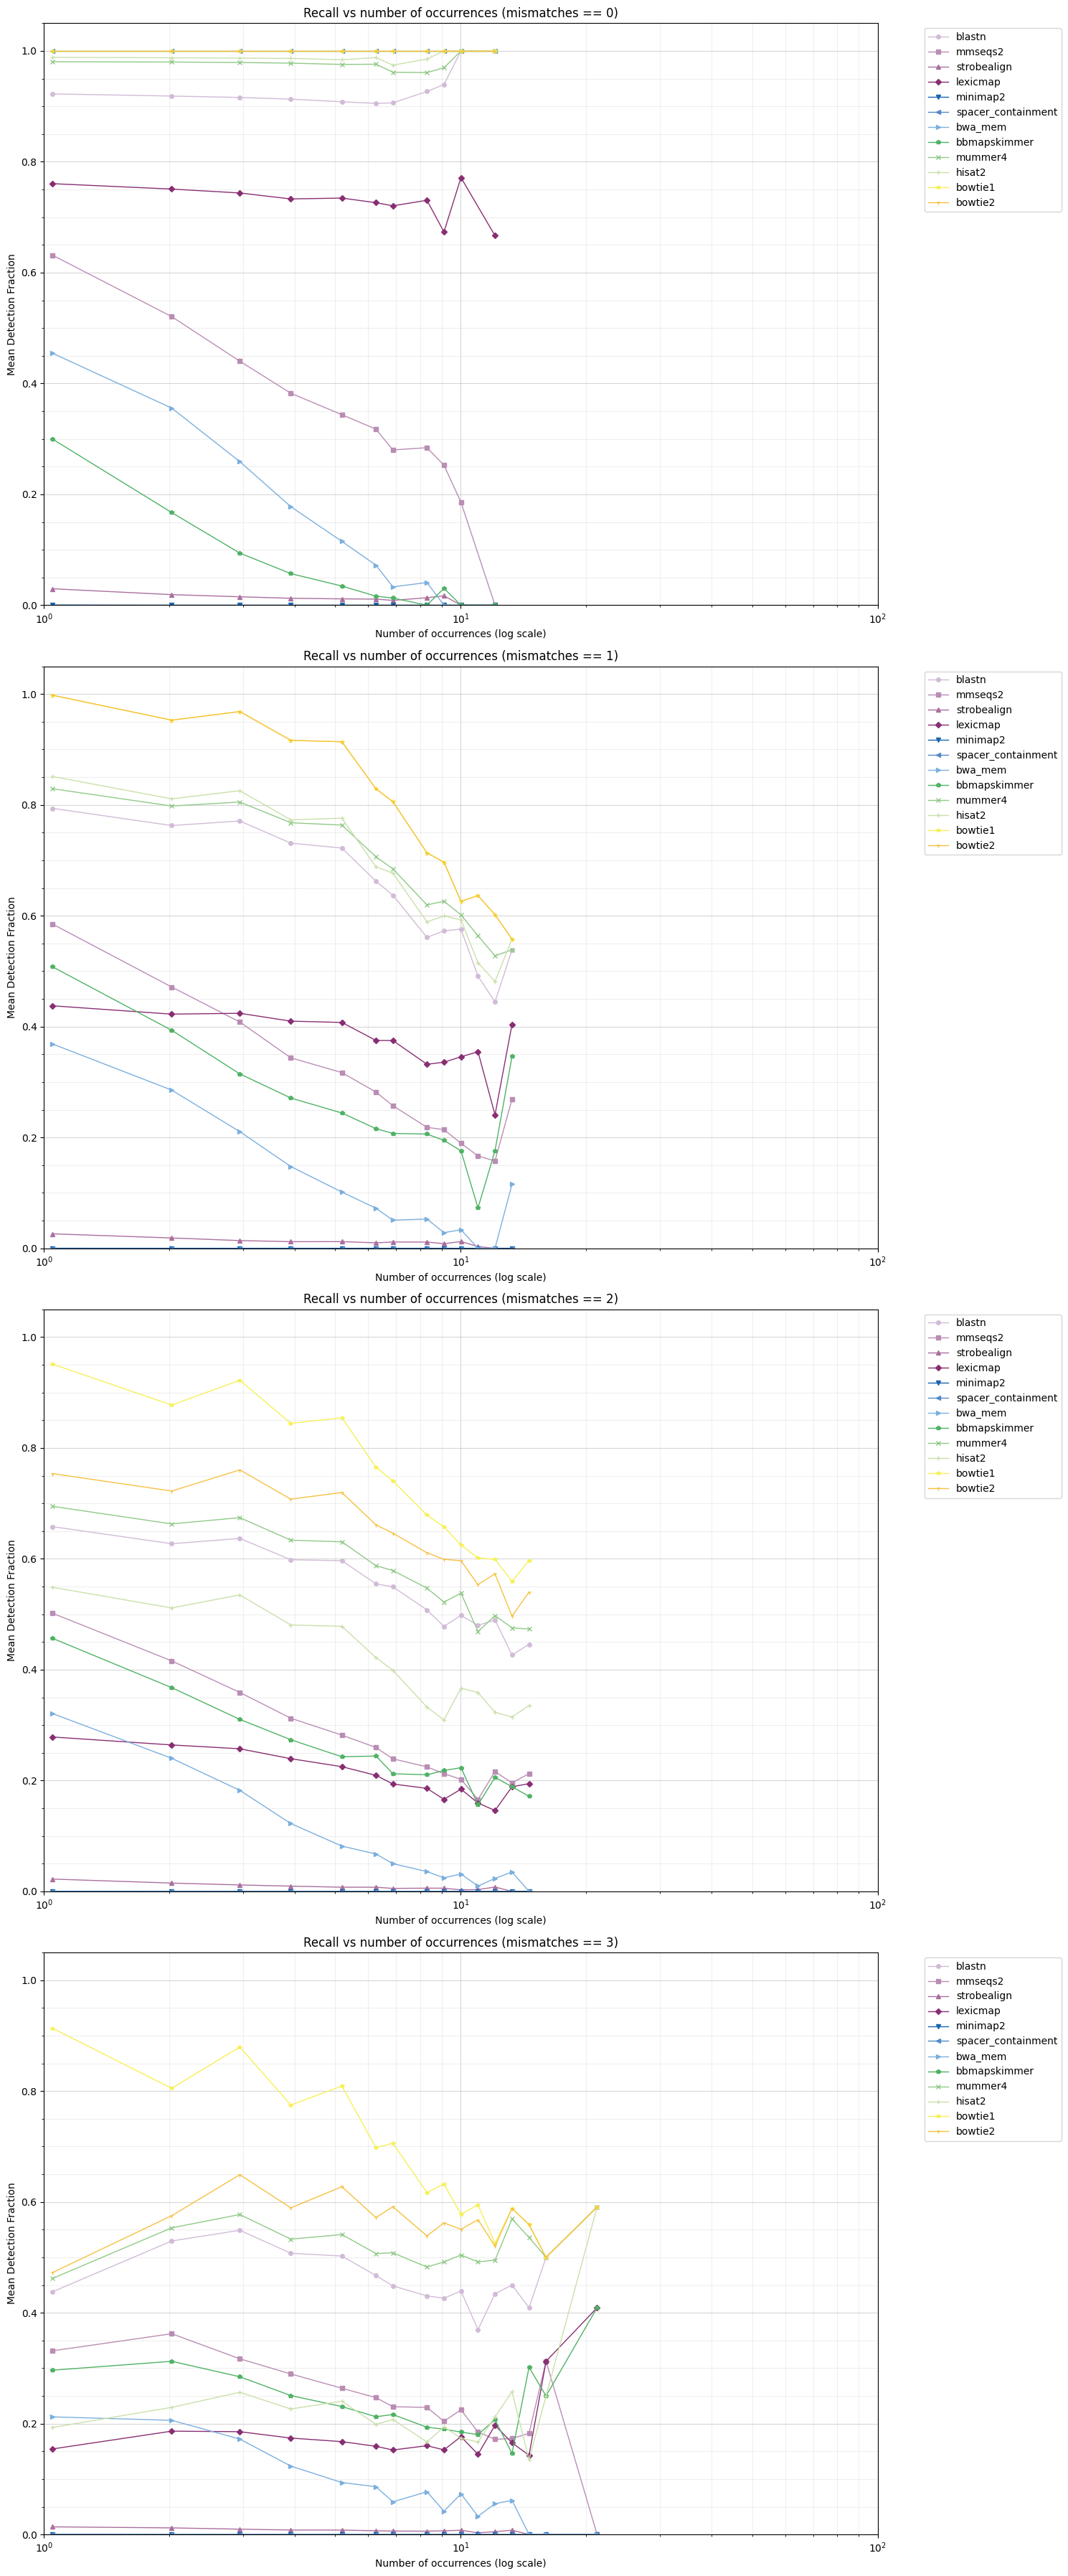

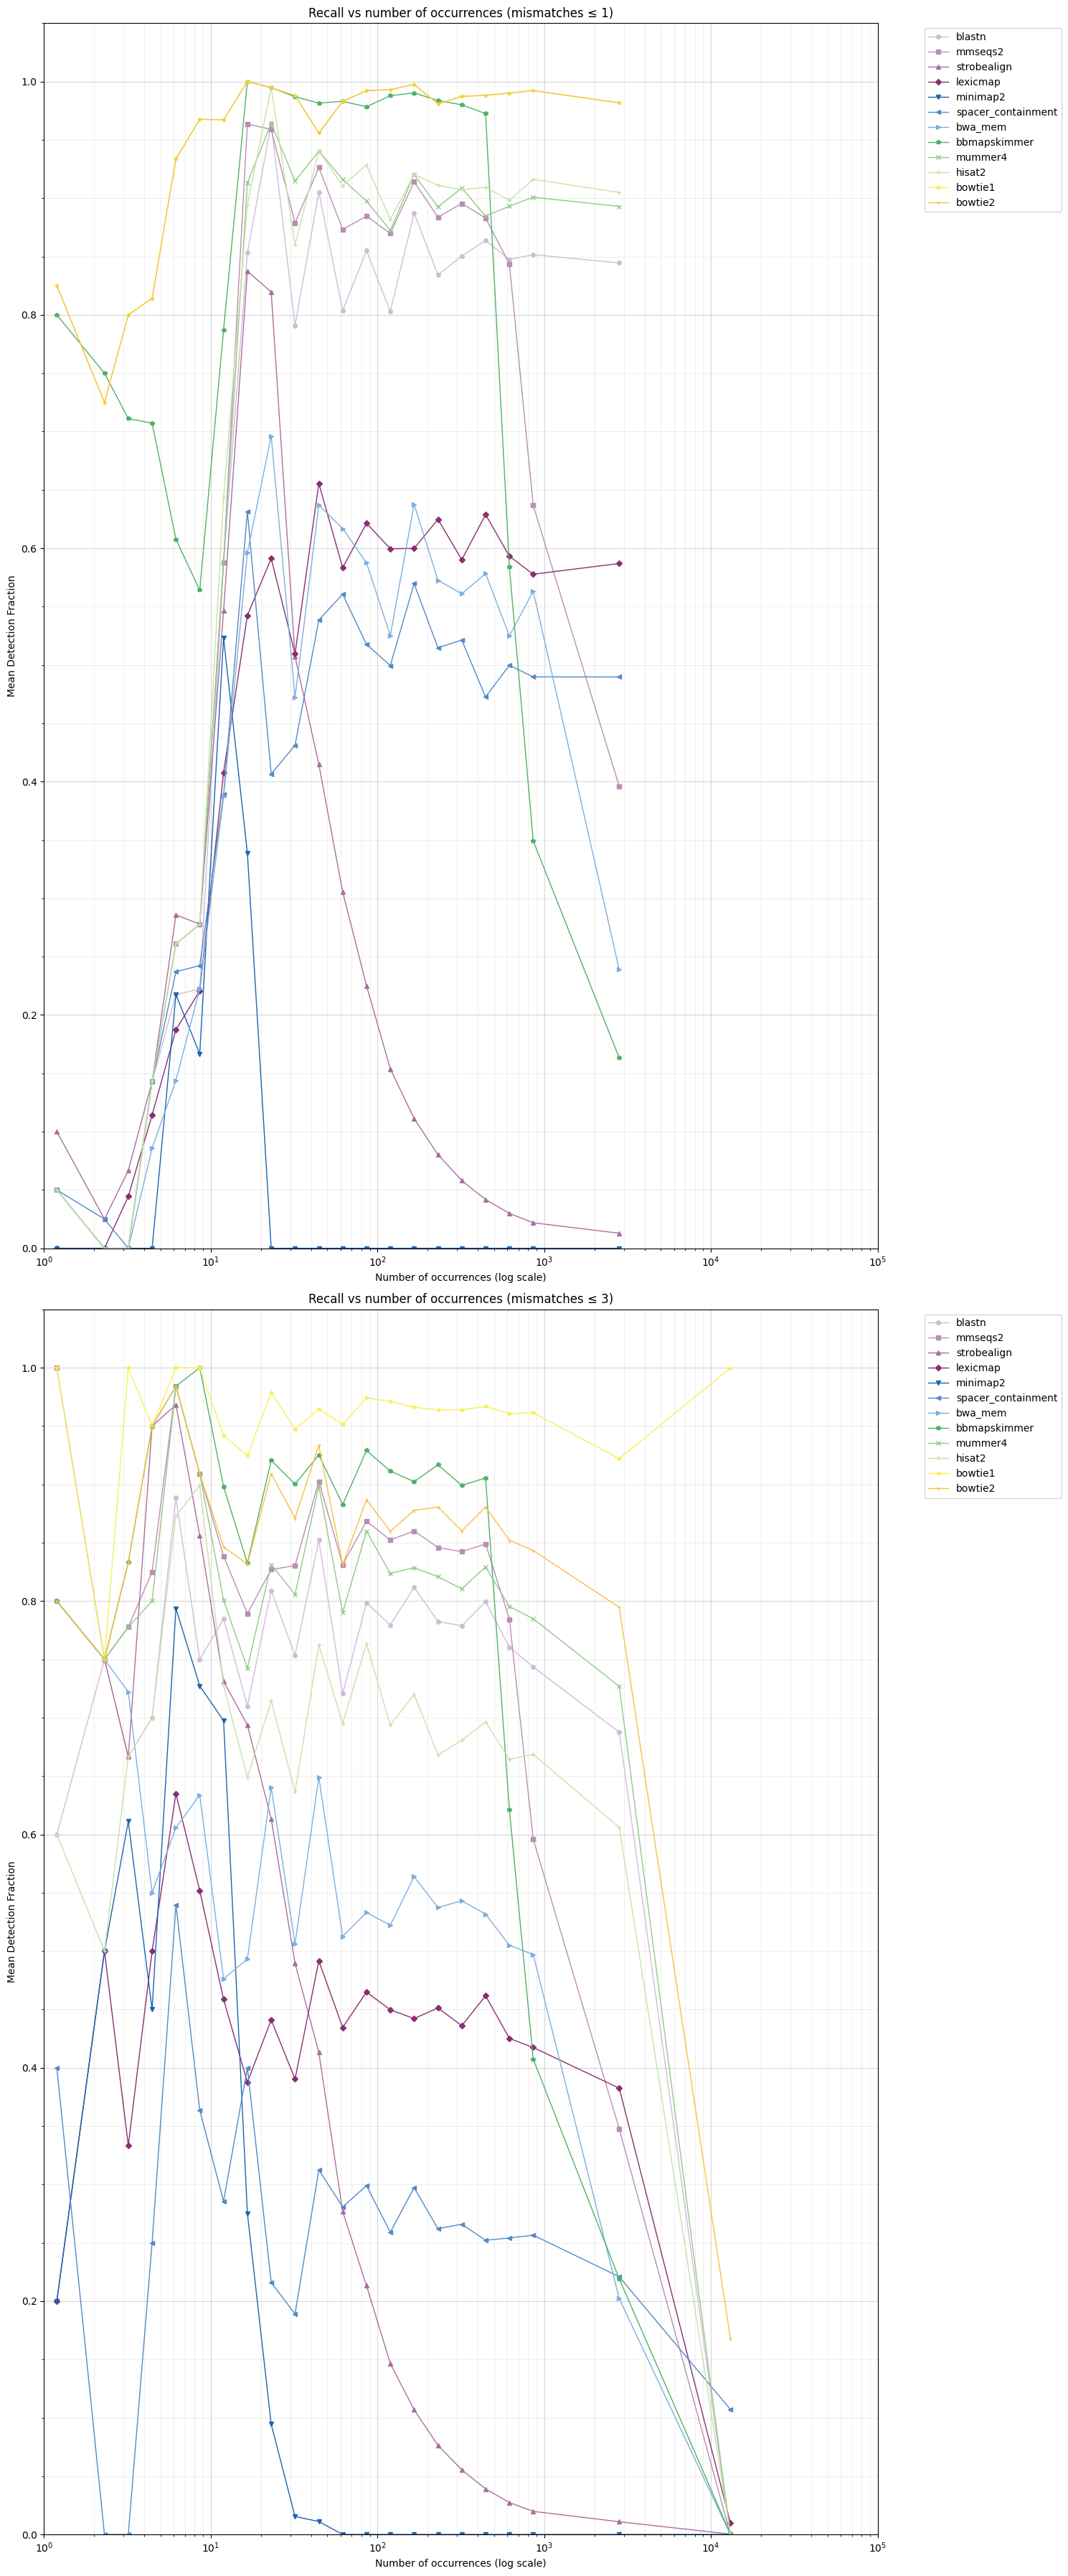

In [24]:
n_mismatches = [0,1,2,3]
plot=plot_combined_recall_vs_occurrences(recalced_results,
                                        tools_list,
                                        n_high_occ_bins=0,
                                        n_bins=50,
                                        max_bin=10**2,
                                        output_prefix=f'results/simulated/plots/recall_vs_occurrences_with_contig_id',
                                        plot_mismatches=n_mismatches,
                                        exact_or_max="exact",
                                        with_contig_id=True,
                                        binning_method="linear")

n_mismatches = [1,3]
plot=plot_combined_recall_vs_occurrences(recalced_results,
                                        tools_list,
                                        n_high_occ_bins=3,
                                        n_bins=25,
                                        max_bin=10**5,
                                        output_prefix=f'results/simulated/plots/recall_vs_occurrences',
                                        plot_mismatches=n_mismatches,
                                        exact_or_max="max",
                                        with_contig_id=False)



In [21]:
# %%bash
# for f in results/simulated/plots/recall_vs_occurrences_*.pdf; do
#     echo $f
#     no_ext=$(basename $f)
#     no_ext=${no_ext%.pdf}
#     echo $no_ext
#     cp $f draft/supp/figures/supp/simulated_${no_ext}.pdf
# done



results/simulated/plots/recall_vs_occurrences_max_nm_0.pdf
recall_vs_occurrences_max_nm_0
results/simulated/plots/recall_vs_occurrences_max_nm_0_3_combined.pdf
recall_vs_occurrences_max_nm_0_3_combined
results/simulated/plots/recall_vs_occurrences_max_nm_3.pdf
recall_vs_occurrences_max_nm_3
results/simulated/plots/recall_vs_occurrences_with_contig_id_exact_nm_0.pdf
recall_vs_occurrences_with_contig_id_exact_nm_0
results/simulated/plots/recall_vs_occurrences_with_contig_id_exact_nm_0_1_2_3_combined.pdf
recall_vs_occurrences_with_contig_id_exact_nm_0_1_2_3_combined
results/simulated/plots/recall_vs_occurrences_with_contig_id_exact_nm_1.pdf
recall_vs_occurrences_with_contig_id_exact_nm_1
results/simulated/plots/recall_vs_occurrences_with_contig_id_exact_nm_2.pdf
recall_vs_occurrences_with_contig_id_exact_nm_2
results/simulated/plots/recall_vs_occurrences_with_contig_id_exact_nm_3.pdf
recall_vs_occurrences_with_contig_id_exact_nm_3


Next, plotting of recall per mismatch - but on a spacer occurences basis, not spacer-contig-pair occurences 

One function to plot tool recall vs number of occurences

Now we chart the distribution of the spacer lengths, number of mismatches, and number of occurrences.

In [22]:
all_ground_truth_verified['mismatches'].max()

3

In [39]:
import altair as alt
import polars as pl

def plot_spacer_distributions(tools_results, spacer_counts_with_tools, output_prefix='results/simulated/plots'):
    """Create a three-panel figure showing spacer length, mismatch, and occurrence distributions using Altair.
    Uses VegaFusion for efficient handling of large datasets.
    """
    # Pre-aggregate in Polars to reduce data size
    spacer_df = tools_results.with_columns(pl.col('spacer_seq').str.len_chars().alias('spacer_length'))
    spacer_df = spacer_df.select([
        'spacer_id', 'spacer_length', 'mismatches'
    ]).unique()

    occurrence_df = spacer_counts_with_tools['n_occurrences'].value_counts()
    mismatches_df = spacer_df['mismatches'].value_counts()
    length_df = spacer_df["spacer_id",'spacer_length'].unique()["spacer_length"].value_counts()

    # Get maximum values for each distribution
    max_occurrences = occurrence_df['n_occurrences'].max()
    max_mismatches = mismatches_df['mismatches'].max()
    max_length = length_df['spacer_length'].max()
   
    # Base chart for occurrence distribution
    base = alt.Chart(occurrence_df).encode(
        tooltip=['n_occurrences:Q', 'count:Q']
    )

    chart3 = base.mark_bar(opacity=0.5).encode(
        alt.X('n_occurrences:Q',
              scale=alt.Scale( domain=[1, max_occurrences]),
              title='Number of Occurrences'),
        alt.Y('count:Q', title='Count')).properties(
        title='B.',
    )

    
    chart1 = alt.Chart(length_df).mark_bar().encode(
        x=alt.X('spacer_length:Q', 
                title='Spacer Length (bp)', 
                axis=alt.Axis(grid=True,tickCount=60),
                scale=alt.Scale(domain=[16, max_length])),
        y=alt.Y("count:Q", axis=alt.Axis(title="Number of Spacers", grid=True,ticks=False,gridDash=[2,2]))
    ).properties(
        title='A.',
    )

    chart2 = alt.Chart(mismatches_df).mark_bar(width=15).encode(
        x=alt.X('mismatches:Q', 
                title='Number of Mismatches', 
                axis=alt.Axis(grid=True,tickCount=6),
                scale=alt.Scale(domain=[0, max_mismatches])),
        y=alt.Y("count:Q", axis=alt.Axis(title="Number of Spacers",  grid=True,ticks=False, gridDash=[2,2])),
    ).properties(
        title='C.',
    )
    
    combined_chart = chart1 | chart3 | chart2
    return combined_chart.configure_title(anchor='start') 

tools_results = recalced_results
spacer_counts_with_tools = create_spacer_counts_with_tools(recalced_results=recalced_results,
                                                           tools_list= tools_list,
                                                           all_ground_truth_verified=all_ground_truth_verified,
                                                           mismatches=3,
                                                           exact_or_max="max",
                                                           with_contig_id=False)

combined_chart =  plot_spacer_distributions(spacer_counts_with_tools=spacer_counts_with_tools,tools_results=all_ground_truth_verified)

combined_chart.save('./results/simulated/plots/spacer_distributions.html')
combined_chart.save('./results/simulated/plots/spacer_distributions.svg',format='svg')
combined_chart.save('./draft/figures/supp/simulated_spacer_distributions.svg',format='svg')
combined_chart.save('./results/simulated/plots/spacer_distributions.pdf',format='pdf')


In [38]:
combined_chart

alt.HConcatChart(...)

In [ ]:
# Print some summary statistics
tools_results = tools_results.with_columns(pl.col('spacer_seq').str.len_chars().alias('spacer_length'))
print("\nSummary Statistics:")
print("\nSpacer Lengths:")
print(f"Mean: {tools_results['spacer_length'].mean():.2f}")
print(f"Median: {tools_results['spacer_length'].median():.2f}")
print(f"Std: {tools_results['spacer_length'].std():.2f}")
print(f"Min: {tools_results['spacer_length'].min()}")
print(f"Max: {tools_results['spacer_length'].max()}")

print("\nMismatches:")
print(f"Mean: {tools_results['mismatches'].mean():.2f}")
print(f"Median: {tools_results['mismatches'].median():.2f}")
print(f"Std: {tools_results['mismatches'].std():.2f}")
print(f"Min: {tools_results['mismatches'].min()}")
print(f"Max: {tools_results['mismatches'].max()}")

print("\nOccurrences:")
print(f"Mean: {spacer_counts_with_tools['n_occurrences'].mean():.2f}")
print(f"Median: {spacer_counts_with_tools['n_occurrences'].median():.2f}")
print(f"Std: {spacer_counts_with_tools['n_occurrences'].std():.2f}")
print(f"Min: {spacer_counts_with_tools['n_occurrences'].min()}")
print(f"Max: {spacer_counts_with_tools['n_occurrences'].max()}")